In [1271]:
import numpy as np
import pickle
import numpy.matlib
import matplotlib.pyplot as plt
# didnt work ??? import functions.py.ipynb as f

# d = 3072
# k = 10
# n = 10000

In [1585]:
# Loades an entire batch
def LoadBatch(filename):
	""" Copied from the dataset website """ 
	with open('Datasets/'+filename, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes') 
	return dict

def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
	""" Converted from matlab code """
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape);
	grad_b = np.zeros((no, 1));
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] -= h
		c1 = ComputeCost(X, Y, W, b_try, lamda)

		b_try = np.array(b)
		b_try[i] += h
		c2 = ComputeCost(X, Y, W, b_try, lamda)

		grad_b[i] = (c2-c1) / (2*h)

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] -= h
			c1 = ComputeCost(X, Y, W_try, b, lamda)

			W_try = np.array(W)
			W_try[i,j] += h
			c2 = ComputeCost(X, Y, W_try, b, lamda)

			grad_W[i,j] = (c2-c1) / (2*h)

	return [grad_W, grad_b]

##############################################################

def ReadData(filename):
    data_batch = LoadBatch(filename)
    
    # get pixel data
    # divide by 255 for single format
    # Maybe have to transpose
    pixel_data = data_batch[b'data'] #/255
    # labels for each image
    labels = data_batch[b'labels']
    # one-hot rep. of labels
    # T -> roterar
    one_hot = np.eye(10)[labels].T
    #print(one_hot.shape)
    return pixel_data, one_hot, labels

def GetMeanAndStd(data):  
    # Kanske ändra
    mean = np.mean(data, 0)
    std = np.std(data, 0) # nånting saknas 
    return mean, std

# input trainings data mean std
def Normalize(train, validation, test, mean, std):
        # convert to floar
        train = np.float64(train)
        validation = np.float64(validation)
        test = np.float64(test)
        
        # Lurigt
        train -= mean 
        train /= std
    
        validation -= mean
        validation /= std
        
        test -= mean
        test /= std
        
        return train.T, validation.T, test.T
        
        #train = train    
def GetWeightAndBias(X, Y):
    W_size = X.shape
    b_size = Y.shape
    # Random seed????
    # loc = mean, scale = std
    np.random.seed(400)
    W = np.random.normal(loc=0.0, scale=0.01, size=(10, 3072))
    b = np.random.normal(loc=0.0, scale=0.01, size=(b_size[0], 1))

    return W, b


def EvaluateClassifier(X, W, b):
   # print(W.shape)
  #  print(X.shape)
    s = np.dot(W, X) + b
    # Softmax returns each probability for each class label
    P = softmax(s)
    return P

# 1. regularization term: calculate lambda * sum(W^2 ij)
# 2. sum it with l_cross + regularization term -> for each x,y in D
# 3. Multiply everything with 1 / length of D
def ComputeCost(X, Y, W, b, lambd):
    #div_D_length = 1 / len(X) * 2
   # print(div_D_length)

    # calculate P using softmax
    P = EvaluateClassifier(X, W, b)
    # Calculate cross-entropy-loss
    l_cross = -np.sum(np.multiply(Y, np.log(P)))
    # calculate regularization term
    reg_term = lambd * np.sum(np.square(W))
    # calculate total cost function
    
    # OBS: |D| is it the length of y+x or only x?
    J = (1 / len(X[1])) * l_cross + reg_term
    
    return J

def ComputeAccuracy(X, y, W, b):

    P = EvaluateClassifier(X,W,b)
    acc = np.mean(y == np.argmax(P, axis=0))
    
    return acc
    
# Tried to do from last slide of L3
# Forward pass is already done since we have already calculated P
def ComputeGradients(X, Y, P, W, lambd):

    n_b = X.shape[1]
    
    # Backward pass
    G_batch = -(Y - P)
    # Backward pass + reg term
    # LCROSS IS WHERE?! see (11) and (10)
    grad_W = 1 / n_b * np.dot(G_batch, X.T) + 2 * lambd * W
    # Backward pass for 
    grad_b = 1 / n_b * np.dot(G_batch, np.ones(shape=(n_b, 1)))
    return grad_W, grad_b

def CompareGradients(X, Y, W, b, lambd, h):
    P = EvaluateClassifier(X, W, b)
    grad_W_a, grad_b_a = ComputeGradients(X, Y, P, W, lambd)
    grad_W_n, grad_b_n = ComputeGradsNumSlow(X, Y, P, W, b, lambd, h)
    
    
    w_rel_error = np.sum(np.abs(grad_W_a - grad_W_n)) / np.maximum(0.0001, np.sum(np.abs(grad_W_a) + np.abs(grad_W_n)))
    b_rel_error = np.sum(np.abs(grad_b_a - grad_b_n)) / np.maximum(0.0001, np.sum(np.abs(grad_b_a) + np.abs(grad_b_n)))


    #print("abs_difference", abs_difference)
   # denominator = np.maximum(0.00001, np.sum(np.abs(g_W) + np.abs(ng_W)))
   # print("denominator ", denominator)
   # kvot = abs_difference / denominator
 #   print(kvot)

    if w_rel_error < 1e-6 and b_rel_error < 1e-6:
        print("ok")
    else:
        print("gradient difference too high")

# Optimization of parameters with mini b GD
# Differs from Batch Gradient Descent and Stochastic GD
def MiniBatchGD(X, Y, GDparams, W, b, lambd):
    
    cost_list = []
    n_batch = GDparams['n_batch']
    epochs = GDparams['n_epochs']
    learning_rate = GDparams['eta']

    n = X.shape[1]
    
    for i in range(epochs):
        #np.random.shuffle(X)
        for j in range(n // n_batch):
            j_start = j*n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            # Random subset of train and corr. labels
            XBatch = X[:, inds]
            YBatch = Y[:, inds]

            # Fwd pass on mini batch
            P = EvaluateClassifier(XBatch, W, b)
            # Backward pass on mini batch
            grad_W, grad_b = ComputeGradients(XBatch, YBatch, P, W, lambd)
            # Update parameters for next iteration
            W = W - learning_rate * grad_W 
            b = b - learning_rate * grad_b

        # Append cost to list for each iteration
        cost_list.append(ComputeCost(XBatch, YBatch, W, b, lambd))
     
    return cost_list

In [1586]:
# Read data
X_train, Y_train, y_test = ReadData('data_batch_1')
X_val_train, Y_val_train, y_val_test = ReadData('data_batch_2')
X_test_train, Y_test_train, y_test_test = ReadData('test_batch')

# Gets mean and std of training data
X_mean, X_std = GetMeanAndStd(X_train)

In [1587]:
# Normalize all data w.r.t. mean and std of training data
X_train_normalized, X_val_train_normalized, X_test_train_normalized = Normalize(X_train, X_val_train, X_test_train, X_mean, X_std)

In [1588]:
# Create model params W and b
# W = Weight, b = bias
W, b = GetWeightAndBias(X_train_normalized, Y_train)

In [1589]:
# Model evaluation (take softmax)
P = EvaluateClassifier(X_train_normalized, W, b)

In [1590]:
# X = dxn array of images (columns)
# Y = 1xn vector of labels (in one-hot) for X
# J = scalar corresponing to sum of the loss of the network's predictions,
# in X relative to ground truth labels and reg. term on W (W= reg?). 
# Lambda = specifies how much penalty to be added 
J = ComputeCost(X_train_normalized, Y_train, W, b, lambd = 0.005)
print("Total cost: ", J)

Total cost:  2.4139004225102796


In [1591]:
A = ComputeAccuracy(X_train_normalized, y_test, W, b)
print(A)

0.1048


In [1592]:
grad_W, grad_b = ComputeGradients(X_train_normalized[0:20, [1]], Y_train[:,[1]], P[0:20, [1]], W[:, 0:20], lambd=0)

In [1593]:
#ngrad_W, ngrad_b = ComputeGradsNumSlow(X_train_normalized[0:20, [1]], Y_train[:,[1]], P_small, W[:, 0:20], b, 0, 1e-6)
                                                

In [1594]:
CompareGradients(X_train[0:20, [1]], Y_train[:, [1]], W[:, 0:20], b, 0, 1e-6)

ok


In [1595]:
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40}

#W_star, b_star = 
cost = MiniBatchGD(X_train_normalized, Y_train, GDparams, W, b, 0)
cost_val = MiniBatchGD(X_val_train_normalized, Y_val_train, GDparams, W, b, 0)

# First cost seems fine compared to example in assignment
print("First cost: ", cost[0])

First cost:  2.0304178821048318


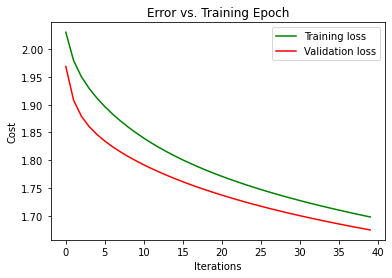

Accuracy train:  0.1048
Accuracy validation:  0.1071


In [1596]:
# Losses looks very weird compared to the ones in the assignment
# Also, why the hell is training losing more than validaiton
# Accuracy low AF
fig, ax = plt.subplots()  
ax.plot(np.arange(GDparams['n_epochs']), cost, 'g', label='Training loss')  
ax.plot(np.arange(GDparams['n_epochs']), cost_val, 'r', label='Validation loss') 
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')
plt.legend()
plt.show()

print("Accuracy train: ", ComputeAccuracy(X_train_normalized, y_test, W, b))
print("Accuracy validation: ", ComputeAccuracy(X_val_train_normalized, y_val_test, W, b))